In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sn_dat = open("sn.dat", 'r')

SN = sn_dat.readlines()

sn_dat.close()

SN_arr = np.zeros((2, 16))

i = 0

for line in SN:
    string = line
    _, JD, Mag, dMag = line.split()
    if JD == "JD":
        continue
    SN_arr[0][i] = JD; SN_arr[1][i] = Mag
    i += 1

In [3]:
JD_norm = SN_arr[0] - SN_arr[0][0]
Mag_dat = SN_arr[1]

In [4]:
# initial setup
# derv_two is array to store the second derivative of Data
# mat_cal is matrix for calculate derv_two
# res_cal is matrix which has y_(i) - 2y_(i + 1) + y_(i + 2) in ith index// need to put .T when calculate

derv_two = np.zeros(14).T

mat_cal = np.zeros((14, 14))

res_cal = np.zeros(14).T

for _ in range(len(JD_norm) - 2):
    mat_cal[_][_] = (JD_norm[_ + 2] - JD_norm[_]) / 3
    if _ != 0:
        mat_cal[_][_ - 1] = (JD_norm[_ + 1] - JD_norm[_]) / 6
    if _ != len(JD_norm) - 3:
        mat_cal[_][_ + 1] = (JD_norm[_ + 2] - JD_norm[_ + 1]) / 6
    
    res_cal[_] = ((Mag_dat[_ + 2] - Mag_dat[_ + 1]) / (JD_norm[_ + 2] - JD_norm[_ + 1])) - ((Mag_dat[_ + 1] - Mag_dat[_]) / (JD_norm[_ + 1] - JD_norm[_]))
    

In [5]:
inv_mat_cal = np.linalg.inv(mat_cal)
derv_two = (res_cal) @ inv_mat_cal
derv_two = np.append(derv_two, 0)
derv_two = np.append(0, derv_two)

print(derv_two)

[ 0.          0.05664704  0.01988859  0.0140973   0.0009718   0.00978961
  0.00678087 -0.00264073  0.0034282   0.00561942 -0.04272256 -0.07861755
  0.02757578 -0.00693747 -0.00301861  0.        ]


In [6]:
# algorithm to find position, return index of the low 
def find_pos(x, JD_norm):
    cpy_JD = JD_norm.copy()

    low = 0
    high = len(cpy_JD) - 1

    while high - low > 1:
        mid = (low + high) // 2
        if JD_norm[mid] > x:
            high = mid
        else:
            low = mid
    
    return low

In [7]:
# since we calculate 2nd dervation of our future graph, we can now interpolate using cubic spline interpolation

def cubic_spline(x, JD_norm, Mag_dat, derv_two):
    # initial setup

    index = find_pos(x, JD_norm)

    x0 = JD_norm[index]
    x1 = JD_norm[index + 1]
    
    y0 = Mag_dat[index]
    y1 = Mag_dat[index + 1]

    t = x1 - x0
    A = (x1 - x) / t
    B = (x - x0) / t
    C = (A**3 - A) * (t**2) / 6
    D = (B**3 - B) * (t**2) / 6

    return A * y0 + B * y1 + C * derv_two[index] + D * derv_two[index + 1]  

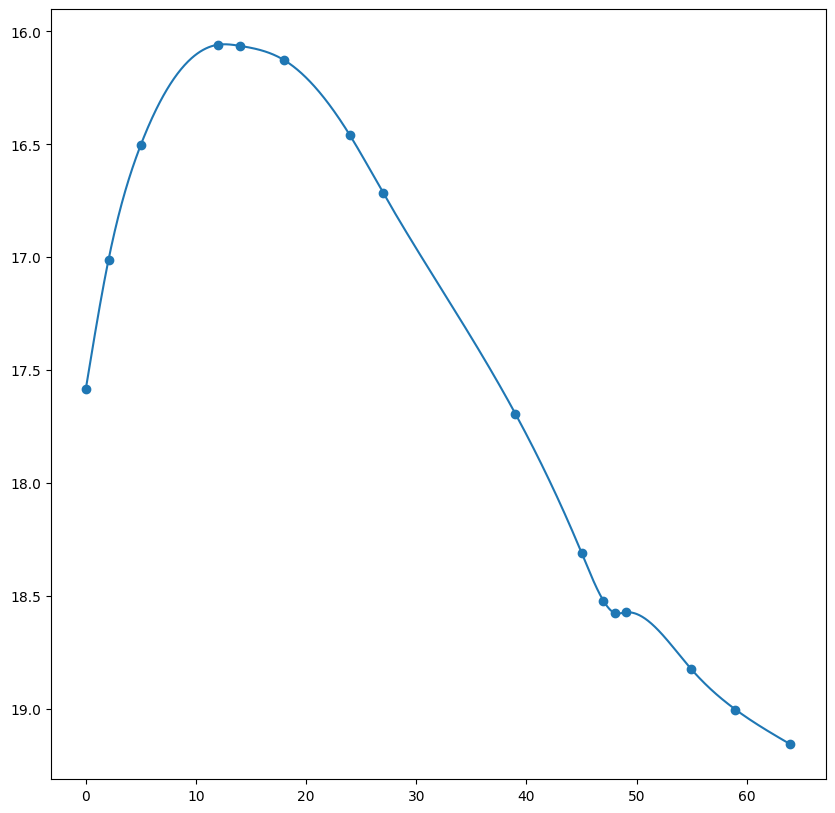

In [8]:
plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
x_axis = np.linspace(JD_norm[0], JD_norm[15], 1000)
y_axis = np.array([cubic_spline(x, JD_norm, Mag_dat, derv_two) for x in x_axis])
plt.scatter(JD_norm, Mag_dat)
plt.plot(x_axis, y_axis)
plt.show()

In [9]:
def first_derv(x, JD_norm, Mag_dat, derv_two):
    index = find_pos(x, JD_norm)
    x0 = JD_norm[index]
    x1 = JD_norm[index + 1]
    y0 = Mag_dat[index]
    y1 = Mag_dat[index + 1]
    
    A = (x1 - x) / (x1 - x0)
    B = (x - x0) / (x1 - x0)
    
    d_x = x1 - x0
    d_y = y1 - y0
    
    return (d_y / d_x) - ((3 * A**2 - 1)/6)*derv_two[index]*d_x + ((3 * B**2 - 1)/6)*derv_two[index + 1]*d_x

In [10]:
def second_derv(x, JD_norm, Mag_dat, derv_two):
    index = find_pos(x, JD_norm)
    x0 = JD_norm[index]
    x1 = JD_norm[index + 1]
    y0 = Mag_dat[index]
    y1 = Mag_dat[index + 1]
    
    A = (x1 - x) / (x1 - x0)
    B = (x - x0) / (x1 - x0)
    
    return A * derv_two[index] + B * derv_two[index + 1]

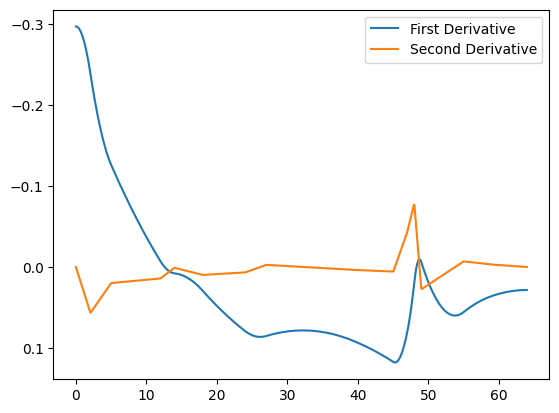

In [16]:
y_fir = np.array([first_derv(x, JD_norm, Mag_dat, derv_two) for x in x_axis])
y_sec = np.array([second_derv(x, JD_norm, Mag_dat, derv_two) for x in x_axis])

plt.figure()
plt.gca().invert_yaxis()
plt.plot(x_axis, y_fir, label="First Derivative")
plt.plot(x_axis, y_sec, label="Second Derivative")
plt.legend()

In [12]:
import Interpolation as ip

result = np.zeros((2, 2, 1000))
cnt = 0
for _ in range(1000):    
    x = x_axis[_]
    if (x > JD_norm[cnt + 1]):
        cnt += 1
        if cnt == 15:
            x = JD_norm[15]
    
    x1 = JD_norm[cnt]; y1 = Mag_dat[cnt]
    x2 = JD_norm[cnt+1]; y2 = Mag_dat[cnt+1]
    result[0][1][_] = ip.linear_interpolation(x, x1, x2, y1, y2)
    result[0][0][_] = x
    
cnt = x_axis[1] - x_axis[0]
x0 = SN_arr[0][0]
for _ in range(1000):
    result[1][0][_] = x0
    result[1][1][_] = ip.Neville_algorithm(SN_arr, x0, 0, 15)
    x0 += cnt

result[1][0] -= SN_arr[0][0]

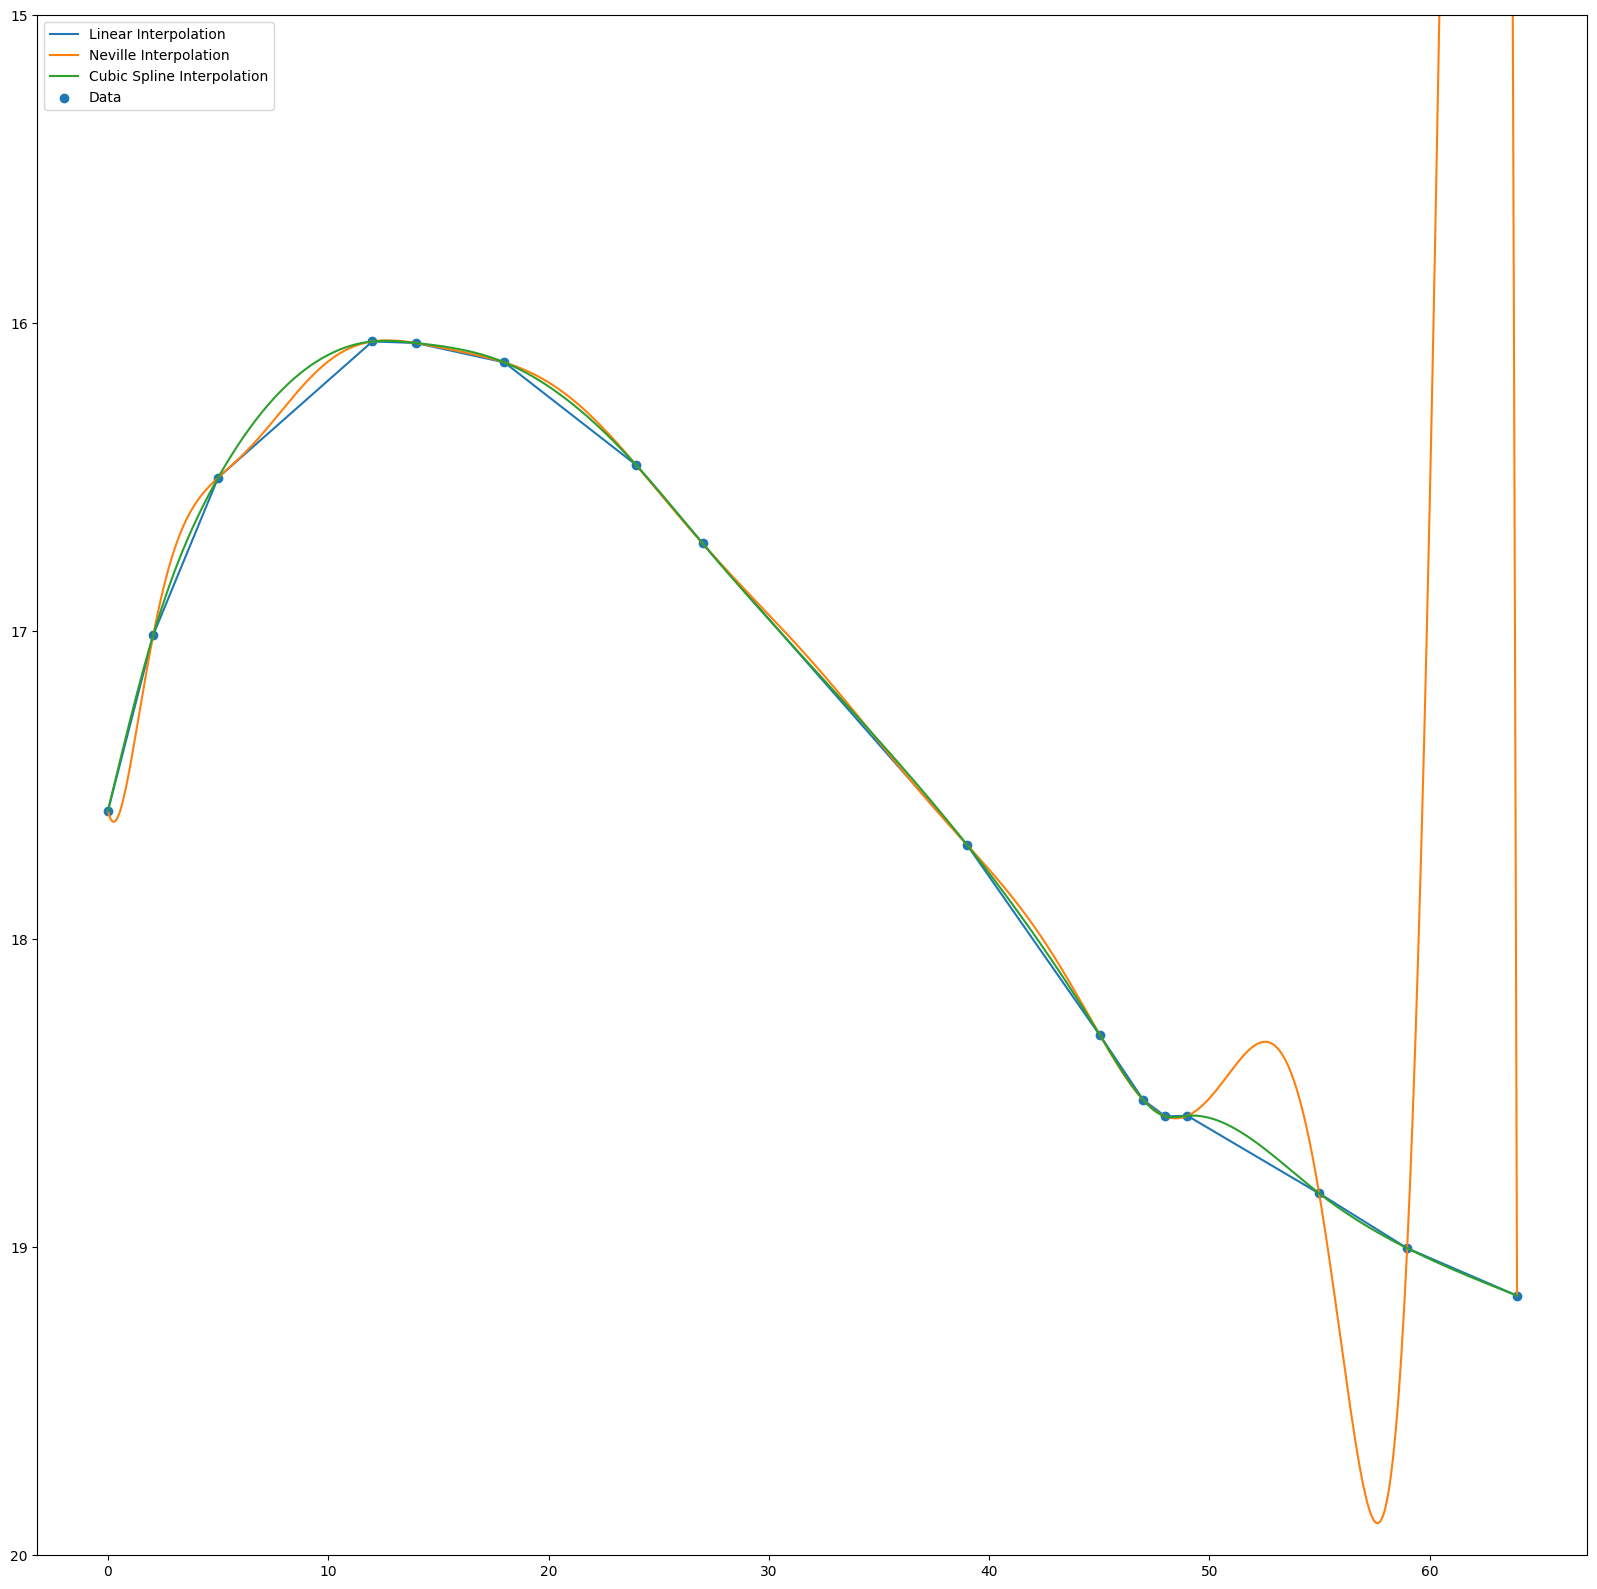

In [13]:
plt.figure(figsize=(20, 20))
plt.ylim(15, 20)
plt.gca().invert_yaxis()
plt.plot(result[0][0], result[0][1], label="Linear Interpolation")
plt.plot(result[1][0], result[1][1], label="Neville Interpolation")
plt.plot(x_axis, y_axis, label="Cubic Spline Interpolation")
plt.scatter(JD_norm, Mag_dat, label="Data")
plt.legend()